# Explainable AI (XAI)

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
import shap
import pickle

from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from interpret import show
from tqdm import tqdm
import random

from interpret.blackbox import LimeTabular

from xailib.explainers.lore_explainer import LoreTabularExplainer

import dice_ml

/home/arakiwi/dm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_STATE = 42
dev_set = pd.read_csv('../data/ml_datasets/undersampling/dev_set.csv').sample(frac = 1, random_state=RANDOM_STATE) # shuffling the data so not to introduce bias
test_set = pd.read_csv('../data/ml_datasets/undersampling/test_set.csv')

In [3]:
dev_set['race_season%autumn'] = dev_set['race_season%autumn'].astype(int)
dev_set['race_season%spring'] = dev_set['race_season%spring'].astype(int)
dev_set['race_season%summer'] = dev_set['race_season%summer'].astype(int)
dev_set['race_season%winter'] = dev_set['race_season%winter'].astype(int)

test_set['race_season%autumn'] = test_set['race_season%autumn'].astype(int)
test_set['race_season%spring'] = test_set['race_season%spring'].astype(int)
test_set['race_season%summer'] = test_set['race_season%summer'].astype(int)
test_set['race_season%winter'] = test_set['race_season%winter'].astype(int)

In [4]:
dev_label = dev_set.pop('label')
test_label = test_set.pop('label')

In [5]:
RANDOM_STATE = 42
RUS = RandomUnderSampler(random_state=RANDOM_STATE)
dev_set, dev_label = RUS.fit_resample(dev_set, dev_label)

In [6]:
model = XGBClassifier(n_estimators=200, max_depth=13, learning_rate=0.108715)
model.fit(dev_set, dev_label)

test_predicitions = model.predict(test_set)
dev_predictions = model.predict(dev_set)

In [39]:
model_report = classification_report(test_label, test_predicitions, output_dict=True)

In [8]:
perturbation_data = dev_set
perturbation_labels = dev_label
perturbation_predictions = dev_predictions

explanation_data = test_set
explanation_labels = test_label
explanation_predictions = test_predicitions

explanations = dict()

## Shap


In [9]:
interventional_explanation_algorithm = shap.TreeExplainer(
    model=model,
    data=dev_set,                       # perturb on a causal model induced on perturbation data
    feature_perturbation="interventional"  # use a causal model
)

distributional_explanation_algorithm = shap.TreeExplainer(
    model=model,
    feature_perturbation="tree_path_dependent"  # condition on the distribution learned on the train data
)

In [10]:
# interventional_explanations = interventional_explanation_algorithm(explanation_data)
# distributional_explanations = distributional_explanation_algorithm(explanation_data)

# with open('under_interventional_explanations.pkl', 'wb') as f:
#     pickle.dump(interventional_explanations, f)

# with open('under_distributional_explanations.pkl', 'wb') as f:
#     pickle.dump(distributional_explanations, f)

In [11]:
interventional_explanations = pickle.load(open('under_interventional_explanations.pkl', 'rb'))
distributional_explanations = pickle.load(open('under_distributional_explanations.pkl', 'rb'))

explanations["shap_interventional"] = interventional_explanations.values
explanations["shap_distributional"] = distributional_explanations.values

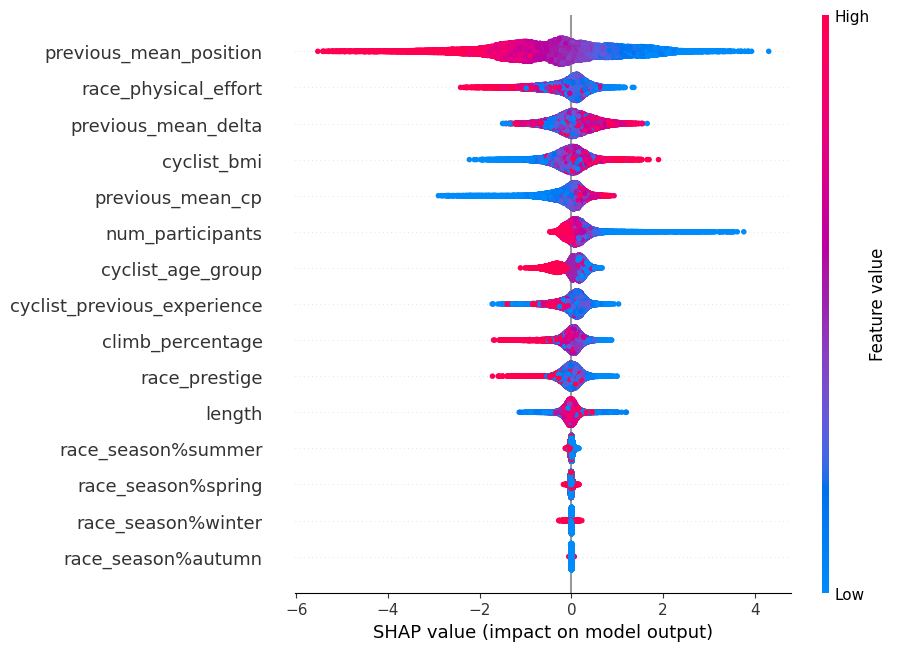

In [12]:
shap.plots.beeswarm(interventional_explanations, max_display=20)

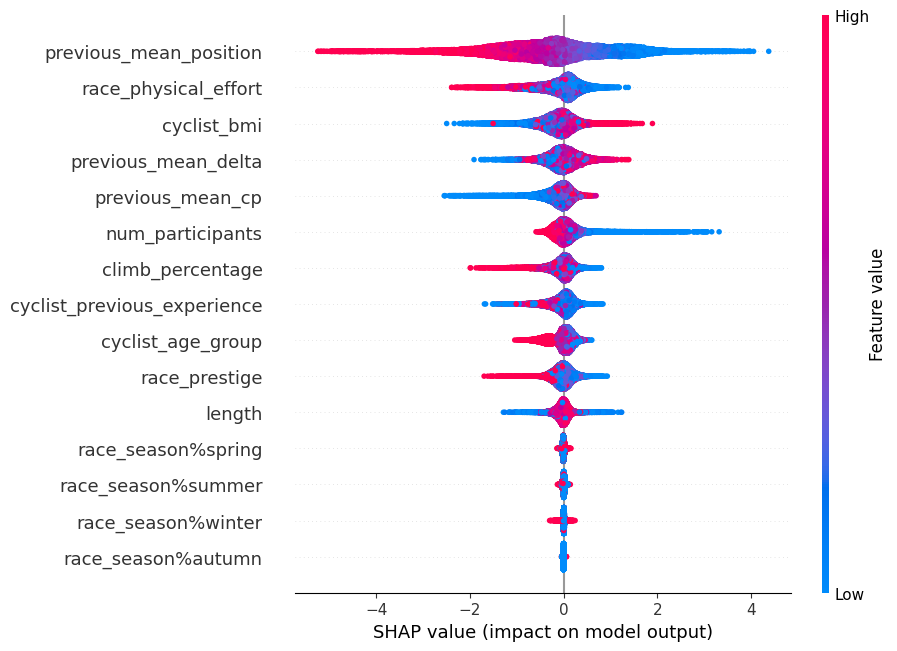

In [13]:
shap.plots.beeswarm(distributional_explanations, max_display=20)

In [14]:
explanation_differences = interventional_explanations.values - distributional_explanations.values
scaling_value = max((abs(interventional_explanations.values).max(), abs(distributional_explanations.values).max()))
maximum_differences_per_instance = explanation_differences.max(axis=1)
maximum_differences_per_feature = explanation_differences.max(axis=0)

<Axes: ylabel='Density'>

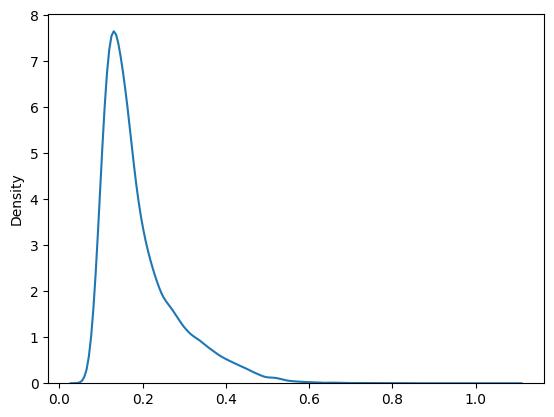

In [15]:
sb.kdeplot(maximum_differences_per_instance)

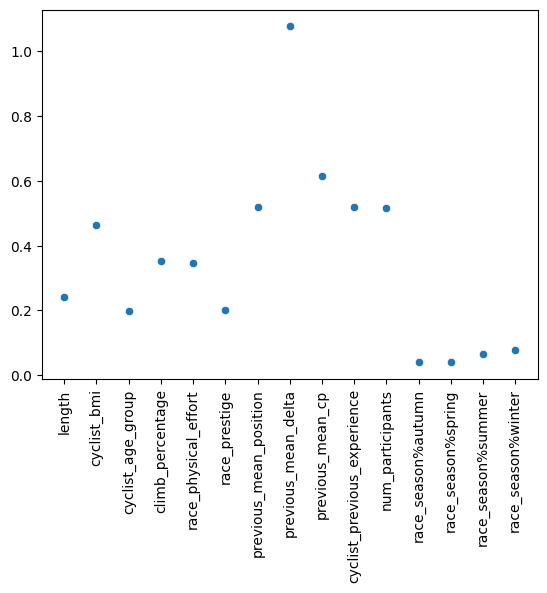

In [16]:
sb.scatterplot(x=dev_set.columns.tolist(), y=maximum_differences_per_feature)
plt.xticks(rotation=90);

In [17]:
interventional_explanations_df = pd.DataFrame(interventional_explanations.values, columns=dev_set.columns.tolist())
interventional_explanations_df.describe().drop("count", axis="rows")

,length,cyclist_bmi,cyclist_age_group,climb_percentage,race_physical_effort,race_prestige,previous_mean_position,previous_mean_delta,previous_mean_cp,cyclist_previous_experience,num_participants,race_season%autumn,race_season%spring,race_season%summer,race_season%winter
mean,-0.015385,-0.045188,0.018068,-0.019140,-0.097492,-0.007720,-0.325641,0.063626,-0.072111,0.017025,0.148207,0.000051,-0.000834,0.005772,-0.004339
std,0.153649,0.390317,0.262484,0.260035,0.455407,0.192327,1.325555,0.409540,0.365262,0.265116,0.311244,0.001869,0.024602,0.028990,0.028130
min,-1.138783,-2.225408,-1.111664,-1.698295,-2.417540,-1.721616,-5.532534,-1.501584,-2.900923,-1.728625,-0.472538,-0.058207,-0.174130,-0.133052,-0.277323
25%,-0.092216,-0.243649,-0.136092,-0.108678,-0.303659,-0.121337,-1.183478,-0.190144,-0.221574,-0.106012,-0.028484,-0.000878,-0.014831,-0.013043,-0.007577
50%,-0.013758,-0.017148,0.076075,0.020156,0.014769,-0.002880,-0.295679,0.054876,-0.000031,0.065099,0.107626,0.000094,-0.002996,0.004169,0.002117
75%,0.061597,0.180209,0.207167,0.126867,0.192175,0.112115,0.562836,0.323101,0.145484,0.186006,0.253638,0.000983,0.011296,0.022594,0.008071
max,1.199083,1.900379,0.671361,0.879991,1.365107,0.998561,4.305218,1.653914,0.931475,1.029751,3.761463,0.064165,0.164436,0.161714,0.228295


In [18]:
distributional_explanations_df = pd.DataFrame(distributional_explanations.values, columns=dev_set.columns.tolist())
distributional_explanations_df.describe().drop("count", axis="rows")

,length,cyclist_bmi,cyclist_age_group,climb_percentage,race_physical_effort,race_prestige,previous_mean_position,previous_mean_delta,previous_mean_cp,cyclist_previous_experience,num_participants,race_season%autumn,race_season%spring,race_season%summer,race_season%winter
mean,-0.028943,-0.128709,-0.037221,-0.056744,-0.091887,-0.021781,-0.248712,-0.003473,-0.121031,-0.039536,0.058158,-0.002825,-0.001694,0.003552,-0.005119
std,0.159718,0.386063,0.230626,0.269200,0.458360,0.190649,1.203656,0.313334,0.300248,0.247180,0.286863,0.003690,0.024346,0.022555,0.028572
min,-1.288122,-2.499875,-1.045175,-1.997653,-2.395134,-1.699790,-5.253061,-1.915188,-2.552077,-1.694180,-0.590825,-0.047078,-0.143479,-0.134475,-0.300802
25%,-0.098906,-0.319617,-0.153015,-0.149409,-0.303146,-0.134667,-1.001234,-0.188977,-0.241627,-0.154682,-0.105372,-0.003619,-0.015697,-0.009661,-0.009561
50%,-0.016590,-0.097014,0.012767,-0.005339,0.014812,-0.017430,-0.237361,-0.007085,-0.066871,0.007346,0.021407,-0.001887,-0.003690,0.003595,0.001791
75%,0.051479,0.087062,0.121435,0.100478,0.193494,0.093452,0.517158,0.189887,0.062860,0.117580,0.159193,-0.000909,0.010828,0.016671,0.008116
max,1.239994,1.897270,0.602804,0.808017,1.381453,0.932975,4.381815,1.392694,0.694123,0.841694,3.322267,0.062527,0.156503,0.143491,0.245355


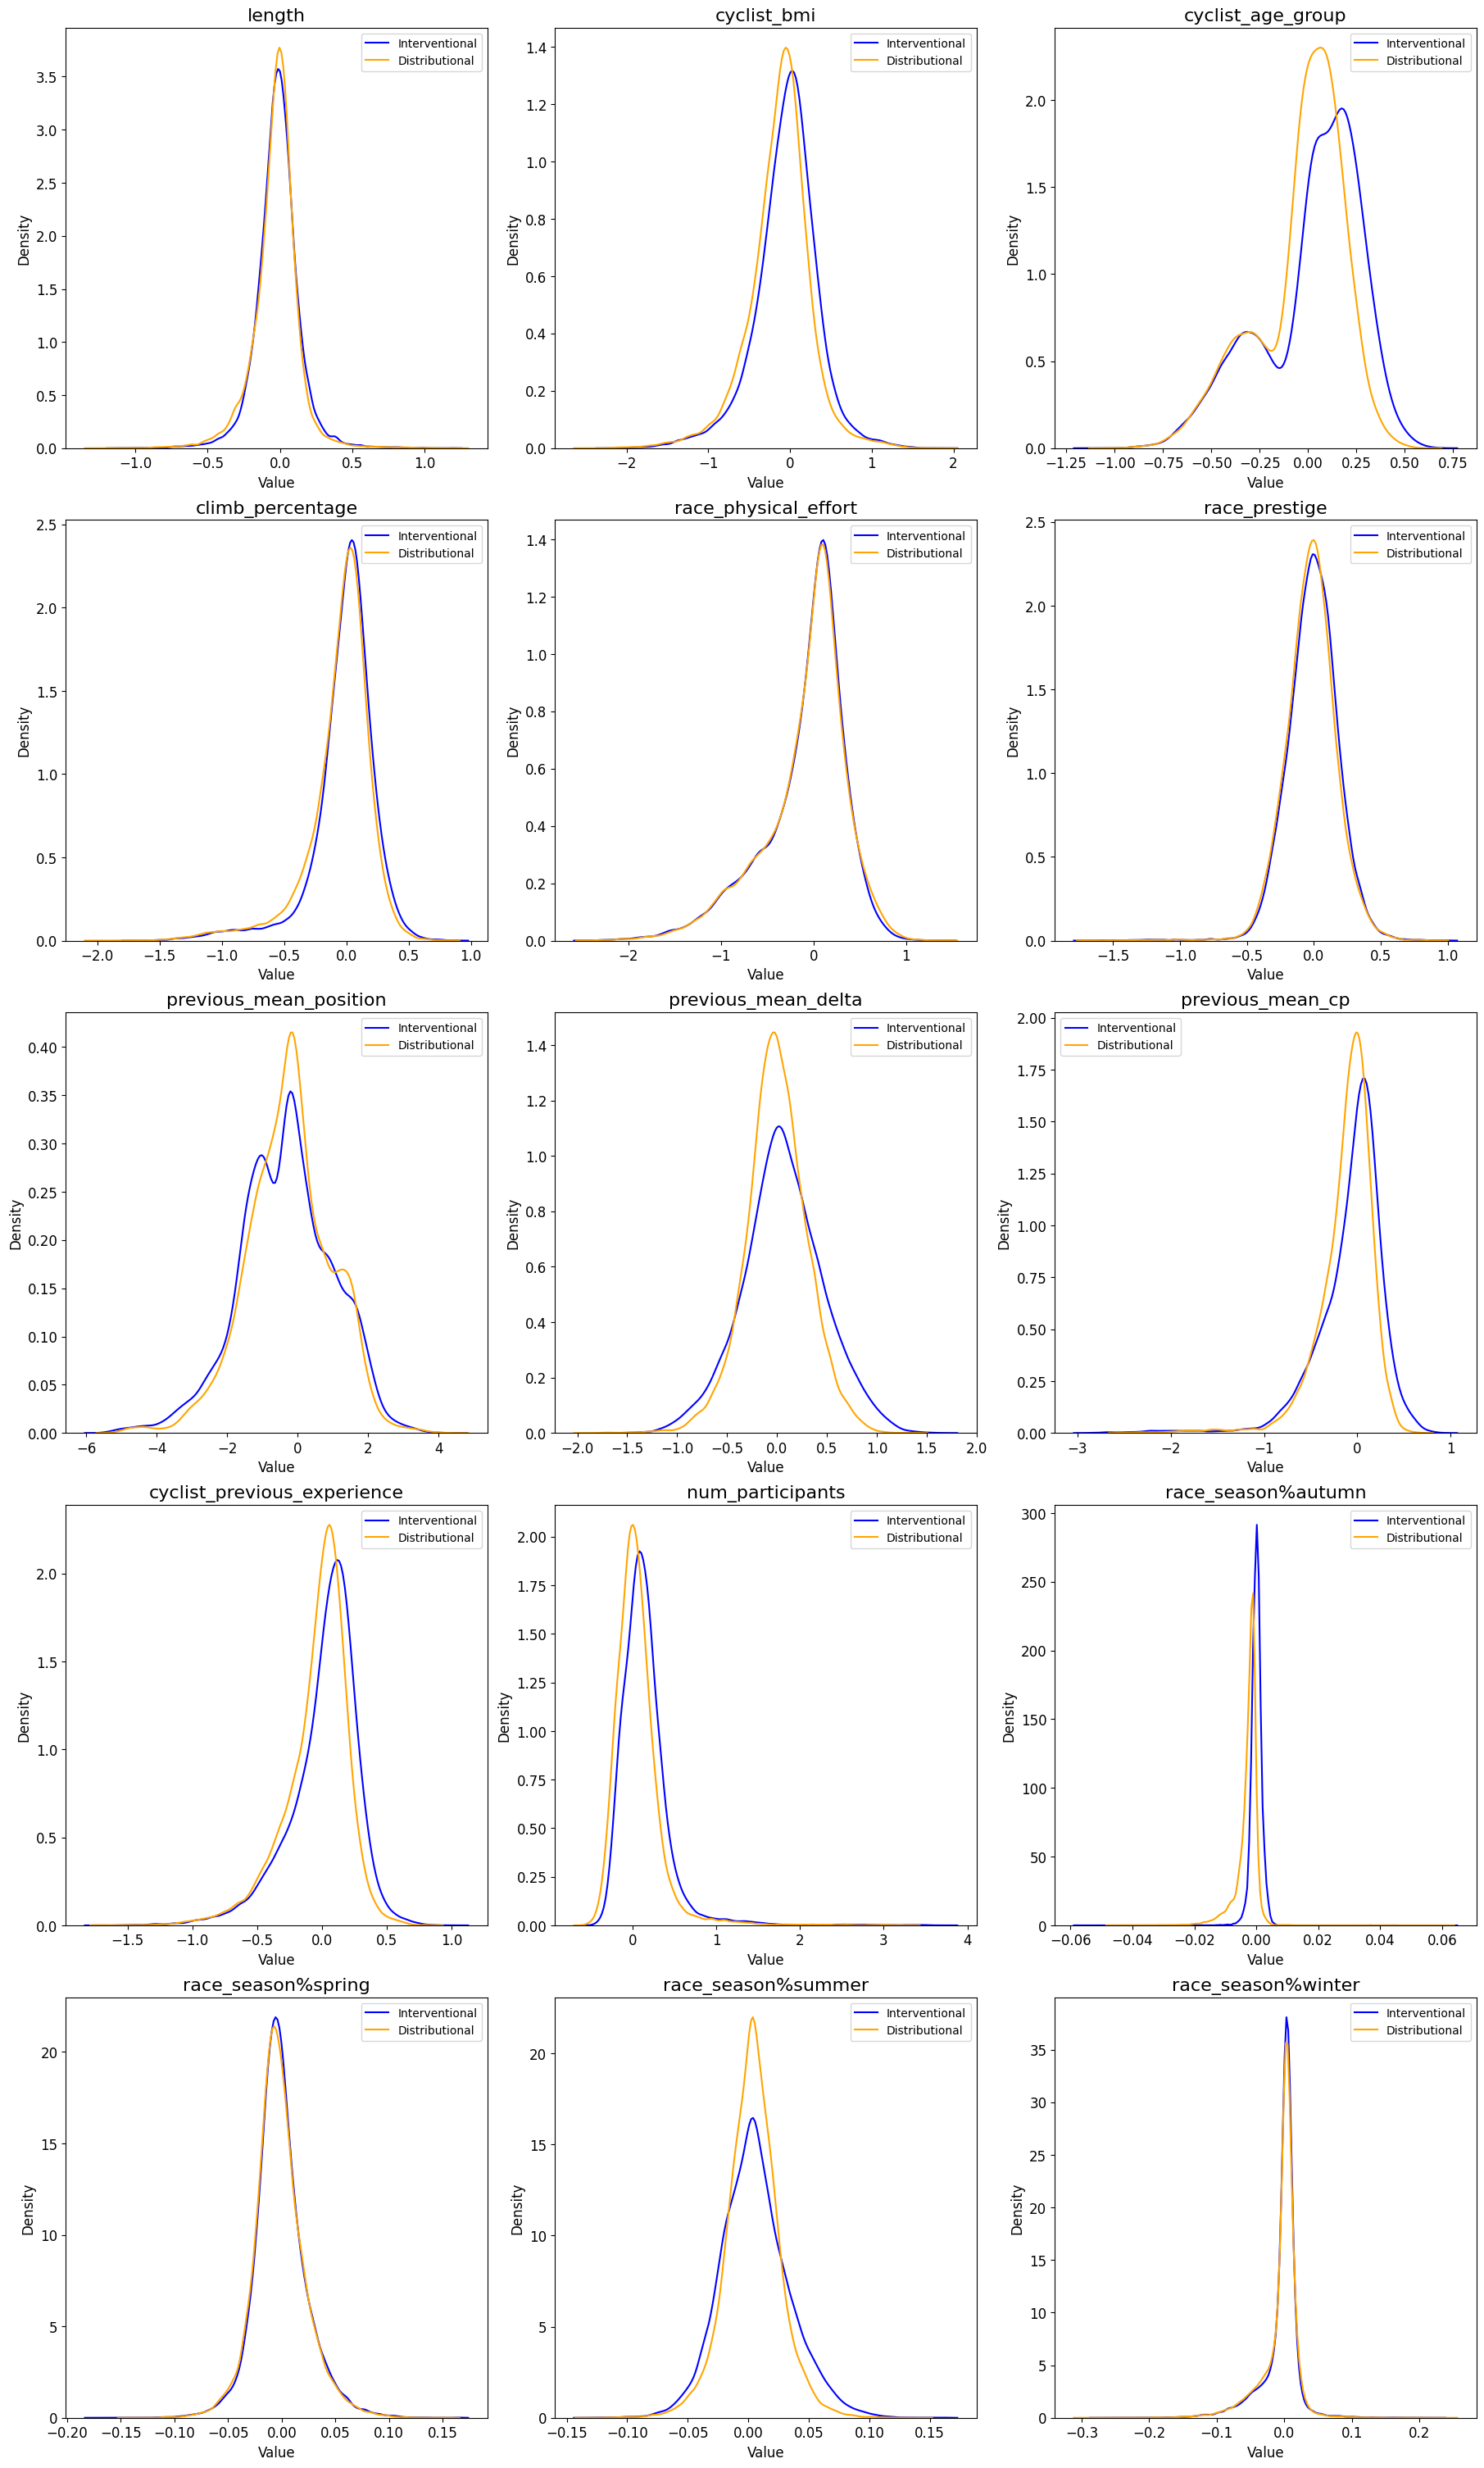

In [19]:
features = interventional_explanations_df.columns  


num_features = len(features)


plots_per_row = 3
num_rows = (num_features + plots_per_row - 1) // plots_per_row 


fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(18, 6 * num_rows), constrained_layout=True)


axes = axes.flatten()

for i, feature in enumerate(features):
    sb.kdeplot(interventional_explanations_df[feature], label='Interventional', color='blue', ax=axes[i])
    sb.kdeplot(distributional_explanations_df[feature], label='Distributional', color='orange', ax=axes[i])
    
    axes[i].set_title(f'{feature}', fontsize=16)
    axes[i].set_xlabel('Value', fontsize=12)
    axes[i].set_ylabel('Density', fontsize=12)
    axes[i].legend(fontsize=10)

    axes[i].tick_params(axis='x', labelsize=12) 
    axes[i].tick_params(axis='y', labelsize=12)  


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.show()

### Validation

In [ ]:
pd.DataFrame(model_report)

,0,1,accuracy,macro avg,weighted avg
precision,0.944744,0.259552,0.684666,0.602148,0.853751
recall,0.675909,0.741851,0.684666,0.708880,0.684666
f1-score,0.788029,0.384558,0.684666,0.586294,0.734448
support,27446.000000,4203.000000,0.684666,31649.000000,31649.000000


Ordiniamo le feature per importanza

In [21]:
# Calculation of mean absolute feature importance
mean_absolute_importances = interventional_explanations_df.abs().mean()

# We sort the columns from the less to the most important respect to mean absolute feature importance
features_by_importance = interventional_explanations_df.columns[mean_absolute_importances.argsort()].tolist()
features_by_importance

['race_season%autumn',
 'race_season%winter',
 'race_season%spring',
 'race_season%summer',
 'length',
 'race_prestige',
 'climb_percentage',
 'cyclist_previous_experience',
 'cyclist_age_group',
 'num_participants',
 'previous_mean_cp',
 'cyclist_bmi',
 'previous_mean_delta',
 'race_physical_effort',
 'previous_mean_position']

In [22]:
random_noise = np.random.rand(test_set.shape[0],)
noise_magnitudes = [eps / 10 for eps in range(1, 10)]

# We corrupt the test set with different noise magnitudes
# Each corruption (different magnitude) is stored in a dict
corruptions_by_feature_and_noise = dict()
for feature in features_by_importance:
    for noise_magnitude in noise_magnitudes:
        corruptions_by_feature_and_noise[(feature, noise_magnitude)] = test_set.copy()
        corruptions_by_feature_and_noise[(feature, noise_magnitude)][feature] = corruptions_by_feature_and_noise[(feature, noise_magnitude)][feature] + random_noise * noise_magnitude

In [23]:
validations_by_feature_and_noise = dict()
for (feature, noise), corruption in corruptions_by_feature_and_noise.items():
    validations_by_feature_and_noise[(feature, noise)] = classification_report(test_label, model.predict(corruption), output_dict=True)

In [ ]:
metric = "f1-score"
corruption_validation = pd.DataFrame([
    (feature, noise_magnitude, validations_by_feature_and_noise[(feature, noise_magnitude)]["macro avg"][metric], "shap")
    for feature, noise_magnitude in validations_by_feature_and_noise
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"]
)
corruption_validation["difference"] = corruption_validation["performance"] - model_report["macro avg"][metric]
corruption_validation

,feature,noise_magnitude,performance,algorithm,difference
0,race_season%autumn,0.1,0.586294,shap,0.000000
1,race_season%autumn,0.2,0.586294,shap,0.000000
2,race_season%autumn,0.3,0.586294,shap,0.000000
3,race_season%autumn,0.4,0.586294,shap,0.000000
4,race_season%autumn,0.5,0.586294,shap,0.000000
...,...,...,...,...,...
130,previous_mean_position,0.5,0.593680,shap,0.007386
131,previous_mean_position,0.6,0.582609,shap,-0.003685
132,previous_mean_position,0.7,0.572790,shap,-0.013504
133,previous_mean_position,0.8,0.565948,shap,-0.020346


In [25]:
corruption_validation.groupby("feature").describe()[["performance", "difference"]]

performance                                \
                                  count      mean       std       min   
feature                                                                 
climb_percentage                    9.0  0.590119  0.000263  0.589852   
cyclist_age_group                   9.0  0.586294  0.000000  0.586294   
cyclist_bmi                         9.0  0.578402  0.003707  0.572438   
cyclist_previous_experience         9.0  0.596549  0.005585  0.586928   
length                              9.0  0.586659  0.000235  0.586294   
num_participants                    9.0  0.586294  0.000000  0.586294   
previous_mean_cp                    9.0  0.593189  0.002924  0.586382   
previous_mean_delta                 9.0  0.586292  0.000081  0.586179   
previous_mean_position              9.0  0.593522  0.025228  0.557477   
race_physical_effort                9.0  0.584122  0.000552  0.583446   
race_prestige                       9.0  0.593102  0.005794  0.584216   
race_season%autumn                  9.0  0.586294  0.000000  0.586294   
race_season%spring                  9.0  0.586294  0.000000  0.586294   
race_season%summer                  9.0  0.586294  0.000000  0.586294   
race_season%winter                  9.0  0.586294  0.000000  0.586294   

                                                                     \
                                  25%       50%       75%       max   
feature                                                               
climb_percentage             0.589877  0.590022  0.590361  0.590449   
cyclist_age_group            0.586294  0.586294  0.586294  0.586294   
cyclist_bmi                  0.575631  0.578284  0.580910  0.583756   
cyclist_previous_experience  0.592981  0.599111  0.601218  0.601839   
length                       0.586599  0.586690  0.586806  0.587020   
num_participants             0.586294  0.586294  0.586294  0.586294   
previous_mean_cp             0.592743  0.594631  0.595101  0.595287   
previous_mean_delta          0.586228  0.586294  0.586352  0.586402   
previous_mean_position       0.572790  0.593680  0.617641  0.625420   
race_physical_effort         0.583628  0.584095  0.584399  0.585004   
race_prestige                0.589048  0.595322  0.597221  0.599306   
race_season%autumn           0.586294  0.586294  0.586294  0.586294   
race_season%spring           0.586294  0.586294  0.586294  0.586294   
race_season%summer           0.586294  0.586294  0.586294  0.586294   
race_season%winter           0.586294  0.586294  0.586294  0.586294   

                            difference                                \
                                 count      mean       std       min   
feature                                                                
climb_percentage                   9.0  0.003825  0.000263  0.003558   
cyclist_age_group                  9.0  0.000000  0.000000  0.000000   
cyclist_bmi                        9.0 -0.007892  0.003707 -0.013856   
cyclist_previous_experience        9.0  0.010255  0.005585  0.000635   
length                             9.0  0.000365  0.000235  0.000000   
num_participants                   9.0  0.000000  0.000000  0.000000   
previous_mean_cp                   9.0  0.006895  0.002924  0.000088   
previous_mean_delta                9.0 -0.000001  0.000081 -0.000115   
previous_mean_position             9.0  0.007228  0.025228 -0.028817   
race_physical_effort               9.0 -0.002172  0.000552 -0.002848   
race_prestige                      9.0  0.006808  0.005794 -0.002078   
race_season%autumn                 9.0  0.000000  0.000000  0.000000   
race_season%spring                 9.0  0.000000  0.000000  0.000000   
race_season%summer                 9.0  0.000000  0.000000  0.000000   
race_season%winter                 9.0  0.000000  0.000000  0.000000   

                                                                     
                                  25%       50%       75%       max

In [26]:
corruption_validation.groupby("noise_magnitude").describe()[["performance", "difference"]]

performance                                                    \
                      count      mean       std       min       25%       50%   
noise_magnitude                                                                 
0.1                    15.0  0.588519  0.009055  0.583756  0.586294  0.586294   
0.2                    15.0  0.589150  0.010261  0.582738  0.586294  0.586294   
0.3                    15.0  0.589198  0.008463  0.580910  0.586294  0.586294   
0.4                    15.0  0.588813  0.006110  0.579366  0.586294  0.586294   
0.5                    15.0  0.588510  0.005429  0.578284  0.586294  0.586294   
0.6                    15.0  0.587649  0.005509  0.577403  0.586257  0.586294   
0.7                    15.0  0.587101  0.007167  0.572790  0.586294  0.586294   
0.8                    15.0  0.586775  0.008609  0.565948  0.586261  0.586294   
0.9                    15.0  0.586117  0.010401  0.557477  0.586236  0.586294   

                                    difference                                \
                      75%       max      count      mean       std       min   
noise_magnitude                                                                
0.1              0.586367  0.620812       15.0  0.002225  0.009055 -0.002538   
0.2              0.587846  0.625420       15.0  0.002856  0.010261 -0.003556   
0.3              0.589672  0.617641       15.0  0.002904  0.008463 -0.005384   
0.4              0.591296  0.605323       15.0  0.002520  0.006110 -0.006928   
0.5              0.592020  0.599990       15.0  0.002216  0.005429 -0.008010   
0.6              0.588422  0.599111       15.0  0.001355  0.005509 -0.008891   
0.7              0.588329  0.601218       15.0  0.000807  0.007167 -0.013504   
0.8              0.588312  0.601839       15.0  0.000481  0.008609 -0.020346   
0.9              0.588463  0.601369       15.0 -0.000177  0.010401 -0.028817   

                                                    
                      25%  50%       75%       max  
noise_magnitude                                     
0.1              0.000000  0.0  0.000073  0.034518  
0.2              0.000000  0.0  0.001552  0.039126  
0.3              0.000000  0.0  0.003378  0.031347  
0.4              0.000000  0.0  0.005002  0.019029  
0.5              0.000000  0.0  0.005727  0.013696  
0.6             -0.000037  0.0  0.002128  0.012817  
0.7              0.000000  0.0  0.002035  0.014924  
0.8             -0.000033  0.0  0.002018  0.015545  
0.9             -0.000057  0.0  0.002169  0.015075

In [27]:
#TODO Additive Addition
#TODO Additive Removal

In [28]:
removed_feature_results = []

for feature in features_by_importance:  # Ordine di importanza delle feature
    # Filtra il dataset per rimuovere la feature corrente
    reduced_train_data = dev_set.drop(columns=[feature])
    reduced_test_data = test_set.drop(columns=[feature])

    # Riaddestra il modello da zero
    model.fit(reduced_train_data, dev_label)

    # Valuta il modello sul dataset di test ridotto
    predictions = model.predict(reduced_test_data)
    report = classification_report(test_label, predictions, output_dict=True)

    # Salva i risultati
    removed_feature_results.append({
        "feature_removed": feature,
        "performance": report["macro avg"]["f1-score"]  # Usa la metrica desiderata
    })

# Converte i risultati in un dataframe per analisi
removed_feature_results_df = pd.DataFrame(removed_feature_results)

In [29]:
removed_feature_results_df.sort_values(by="performance", ascending=False)

,feature_removed,performance
14,previous_mean_position,0.604275
6,climb_percentage,0.588473
9,num_participants,0.587382
12,previous_mean_delta,0.587236
3,race_season%summer,0.586701
7,cyclist_previous_experience,0.585327
1,race_season%winter,0.585085
8,cyclist_age_group,0.585010
0,race_season%autumn,0.584756
4,length,0.584541


In [30]:
added_feature_results = []

# Inizia con un dataset vuoto (o con una base minimale, se necessario)
base_train_data = pd.DataFrame(index=dev_set.index)
base_test_data = pd.DataFrame(index=test_set.index)
old_performance = 0.5

for feature in features_by_importance:  # Ordine di importanza delle feature
    # Aggiungi la feature corrente al dataset base
    base_train_data[feature] = dev_set[feature]
    base_test_data[feature] = test_set[feature]

    # Riaddestra il modello con le feature attuali
    model.fit(base_train_data, dev_label)

    # Valuta il modello sul dataset di test aggiornato
    predictions = model.predict(base_test_data)

    report = classification_report(test_label, predictions, output_dict=True)

    # Salva i risultati
    added_feature_results.append({
        "feature_added": feature,
        "performance_gain": report["macro avg"]["f1-score"] - old_performance  # Usa la metrica desiderata
    })

    old_performance = report["macro avg"]["f1-score"]

# Converte i risultati in un dataframe per analisi
added_feature_results_df = pd.DataFrame(added_feature_results)

In [31]:
added_feature_results_df.sort_values(by="performance_gain", ascending=False)

,feature_added,performance_gain
4,length,0.077985
10,previous_mean_cp,0.050672
11,cyclist_bmi,0.046229
8,cyclist_age_group,0.034719
1,race_season%winter,0.028724
7,cyclist_previous_experience,0.025411
9,num_participants,0.024253
12,previous_mean_delta,0.021101
5,race_prestige,0.006188
13,race_physical_effort,0.004050


## Lime

In [32]:
set_visualize_provider(InlineProvider())

In [37]:
# Reorder columns of dev_set accordingly
dev_set = dev_set[model.feature_names_in_]

explanation_algorithm = LimeTabular(model, dev_set)
explanations["lime"] = np.array([np.array(e["scores"])
                                    for e in tqdm(explanation_algorithm.explain_local(dev_set[:100], dev_label[:100])._internal_obj["specific"])])

100%|██████████| 100/100 [00:00<00:00, 672164.10it/s]


### Validation

In [41]:
metric = "f1-score"
corruption_validation_lime = pd.DataFrame([
    (feature, noise_magnitude, validations_by_feature_and_noise[(feature, noise_magnitude)]["macro avg"][metric], "lime")
    for feature, noise_magnitude in validations_by_feature_and_noise
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"]
)
corruption_validation_lime["difference"] = corruption_validation_lime["performance"] - model_report["macro avg"][metric]

corruption_validation = pd.concat((corruption_validation, corruption_validation_lime))
corruption_validation_lime

,feature,noise_magnitude,performance,algorithm,difference
0,race_season%autumn,0.1,0.586294,lime,0.000000
1,race_season%autumn,0.2,0.586294,lime,0.000000
2,race_season%autumn,0.3,0.586294,lime,0.000000
3,race_season%autumn,0.4,0.586294,lime,0.000000
4,race_season%autumn,0.5,0.586294,lime,0.000000
...,...,...,...,...,...
130,previous_mean_position,0.5,0.593680,lime,0.007386
131,previous_mean_position,0.6,0.582609,lime,-0.003685
132,previous_mean_position,0.7,0.572790,lime,-0.013504
133,previous_mean_position,0.8,0.565948,lime,-0.020346


In [35]:
corruption_validation

,feature,noise_magnitude,performance,algorithm,difference
0,race_season%autumn,0.1,0.586294,shap,0.000000
1,race_season%autumn,0.2,0.586294,shap,0.000000
2,race_season%autumn,0.3,0.586294,shap,0.000000
3,race_season%autumn,0.4,0.586294,shap,0.000000
4,race_season%autumn,0.5,0.586294,shap,0.000000
...,...,...,...,...,...
130,previous_mean_position,0.5,0.823149,lime,0.089562
131,previous_mean_position,0.6,0.822980,lime,0.089392
132,previous_mean_position,0.7,0.822424,lime,0.088837
133,previous_mean_position,0.8,0.822501,lime,0.088913


## Lore

In [36]:
explanation_algorithm = LoreTabularExplainer(model)
configuration = {
    "neigh_type": "rndgen", # metodo di generazione del dataset locale (in questo caso random)
    "size": 1000, # dimensione del dataset locale generato
    "ocr": 0.1, # probabilità di "cambiamento" di una feature durante la perturbazione
    "ngen": 100 # numero di generazioni 
}

lore_train_data = pd.concat((dev_set, dev_label), axis="columns")
explanation_algorithm.fit(lore_train_data, "label", config=configuration)
explanation = explanation_algorithm.explain(dev_set.iloc[0].values)

KeyboardInterrupt: 

In [ ]:
# restituisce regole decisionali che descrivono come il modello ha preso la decisione per l'istanza specifica
explanation.getRules()

{'premise': [{'att': 'previous_mean_position',
   'op': '>',
   'thr': 0.4615142494440079,
   'is_continuous': True},
  {'att': 'num_participants', 'op': '>', 'thr': 155.5, 'is_continuous': True},
  {'att': 'previous_mean_cp',
   'op': '<=',
   'thr': 0.0015025963657535613,
   'is_continuous': True},
  {'att': 'cyclist_previous_experience',
   'op': '>',
   'thr': 0.016258275136351585,
   'is_continuous': True},
  {'att': 'previous_mean_delta',
   'op': '<=',
   'thr': 1174.3203735351562,
   'is_continuous': True},
  {'att': 'cyclist_bmi',
   'op': '<=',
   'thr': 22.292110443115234,
   'is_continuous': True},
  {'att': 'race_physical_effort',
   'op': '<=',
   'thr': 0.3122025579214096,
   'is_continuous': True}],
 'cons': 0,
 'class_name': 'label'}

In [ ]:
# genera le regole controfattuali -> condizioni che se cambiate avrebbero portate ad una predizione diversa
explanation.getCounterfactualRules()

[{'premise': [{'att': 'previous_mean_position',
    'op': '<=',
    'thr': 0.22918780148029327,
    'is_continuous': True},
   {'att': 'previous_mean_cp',
    'op': '<=',
    'thr': 0.0023490135790780187,
    'is_continuous': True},
   {'att': 'previous_mean_cp',
    'op': '>',
    'thr': 0.0019169999868609011,
    'is_continuous': True},
   {'att': 'climb_percentage',
    'op': '>',
    'thr': 0.008869119919836521,
    'is_continuous': True},
   {'att': 'race_physical_effort',
    'op': '>',
    'thr': 0.00041567860171198845,
    'is_continuous': True},
   {'att': 'length', 'op': '<=', 'thr': 156.25, 'is_continuous': True}],
  'cons': 1,
  'class_name': 'label'}]

In [ ]:
explanation.plotRules()

In [ ]:
explanation.expDict["fidelity"]

0.9869513491557442

In [ ]:
explanation.expDict.keys()

dict_keys(['bb_pred', 'dt_pred', 'rule', 'crules', 'deltas', 'fidelity', 'dt'])

## Counterfactuals Explainations

In [ ]:
# need to convert data to the Dice format
dice_train_dataset = dev_set.copy()
dice_train_dataset["over_threshold"] = dev_label
dice_dataset = dice_ml.Data(
    dataframe=dice_train_dataset,
    outcome_name="over_threshold",
    continuous_features=dice_train_dataset.columns.tolist()[:-1]
)

dice_model = dice_ml.Model(
    model=model,
    backend="sklearn",  # dice supports several frameworks, e.g., pytorch, tensorflow
)

In [ ]:
# the Dice object interfaces the counterfactual search
explanation_algorithm = dice_ml.Dice(
    dice_dataset,
    dice_model,
    method="random"  # random search for counterfactuals
    # method="gradient"  # gradient ASCent
    # method="genetic"  # genetic algorithm for search
)

explanation = explanation_algorithm.generate_counterfactuals(
    dice_train_dataset.head(1).drop("over_threshold", axis="columns"),
    total_CFs=10,  # number of counterfactuals to generate
)

100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


In [ ]:
explanation.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,race_season%autumn,race_season%winter,race_season%spring,race_season%summer,length,race_prestige,climb_percentage,cyclist_previous_experience,cyclist_age_group,num_participants,previous_mean_cp,cyclist_bmi,previous_mean_delta,race_physical_effort,previous_mean_position,over_threshold
0,0,0,1,0,4.0,0.0896,0.087,0.024271,0,176,0.001407,19.535423,201.117645,0.000783,0.46815,0



Diverse Counterfactual set (new outcome: 1)


,race_season%autumn,race_season%winter,race_season%spring,race_season%summer,length,race_prestige,climb_percentage,cyclist_previous_experience,cyclist_age_group,num_participants,previous_mean_cp,cyclist_bmi,previous_mean_delta,race_physical_effort,previous_mean_position,over_threshold
0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.07078132,1.0
1,-,-,-,-,-,0.77032167,-,-,-,-,-,-,-,-,0.17334784,1.0
2,-,-,-,-,-,-,-,0.8,-,-,0.1998232626,-,-,-,-,1.0
3,-,-,-,-,271.0,-,-,-,-,-,-,26.977854,-,-,-,1.0
4,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.15366109,1.0
5,-,-,-,-,-,-,-,-,-,56.0,-,-,-,-,-,1.0
6,-,-,-,-,-,-,-,-,-,-,0.00127250209,-,-,-,0.06936122,1.0
7,-,-,-,-,-,-,-,-,-,22.0,-,-,-,-,-,1.0
8,-,-,-,-,-,-,-,-,-,68.0,-,-,-,-,-,1.0
9,-,-,-,-,-,-,-,0.6,-,-,0.10120142409,-,-,-,-,1.0


In [ ]:
#TODO CHANGE FEATURES

explanation = explanation_algorithm.generate_counterfactuals(
    dice_train_dataset.head(1).drop("over_threshold", axis="columns"),
    total_CFs=10,  # number of counterfactuals to generate
    permitted_range= {  # feature constraints
        "capital_loss": [-0.217127, 0.0]
    },
    features_to_vary = ["hours_worked_per_week", "capital_loss", "capital_gain"],  # more feature constraints
    stopping_threshold = 0.2
)

  0%|          | 0/1 [00:00<?, ?it/s]


UserConfigValidationException: Got features {'capital_loss', 'capital_gain', 'hours_worked_per_week'} which are not present in training data

In [ ]:
explanation.visualize_as_dataframe(show_only_changes=True)

In [ ]:
explanation = explanation_algorithm.generate_counterfactuals(
    dice_train_dataset.head(1).drop("over_threshold", axis="columns"),
    total_CFs=10,  # number of counterfactuals to generate
    features_to_vary = ["hours_worked_per_week"],  # more feature constraints
    stopping_threshold = 0.2
)

In [ ]:
help(explanation_algorithm.generate_counterfactuals)